# Landmarks (OSM Data)
Four scores are here computed to extract computation landmarks: structural, visual, pragmatic.
Currently, the user has to provide the building shapefile, collected independently. The height is the only necessary field, plus two datasets containing respectively information about cultural/historical landmarks (e.g. position of listed important buildings) and land-use.

In [7]:
import osmnx as ox, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

## Obtaining the Data

Fill the list 'places' with the names of the cities of interest. Buildings footprints are dowloaded for each city from OpenStreetMap within a certain distance from the centre of each city. The distance is set by the user. Each geodataframe is projected automatically (check OSMNx documentation for more information). The geodataframes are then cleaned and only relevant columns are kept. 

In [8]:
distance_from_center = 1000
places = ['London, UK', 'Torino, Italy', 'Berlin, Germany', 'Beograd, Serbia', 'New York, US', 'Cairo, Egypt']
buildings_gdfs = []

for place in places:
    buildings_gdf = ci.get_buildings_fromOSM(place, 'distance_from_address', epsg = None, distance = distance_from_center)
    buildings_gdfs.append(buildings_gdf)

**Visualisation**

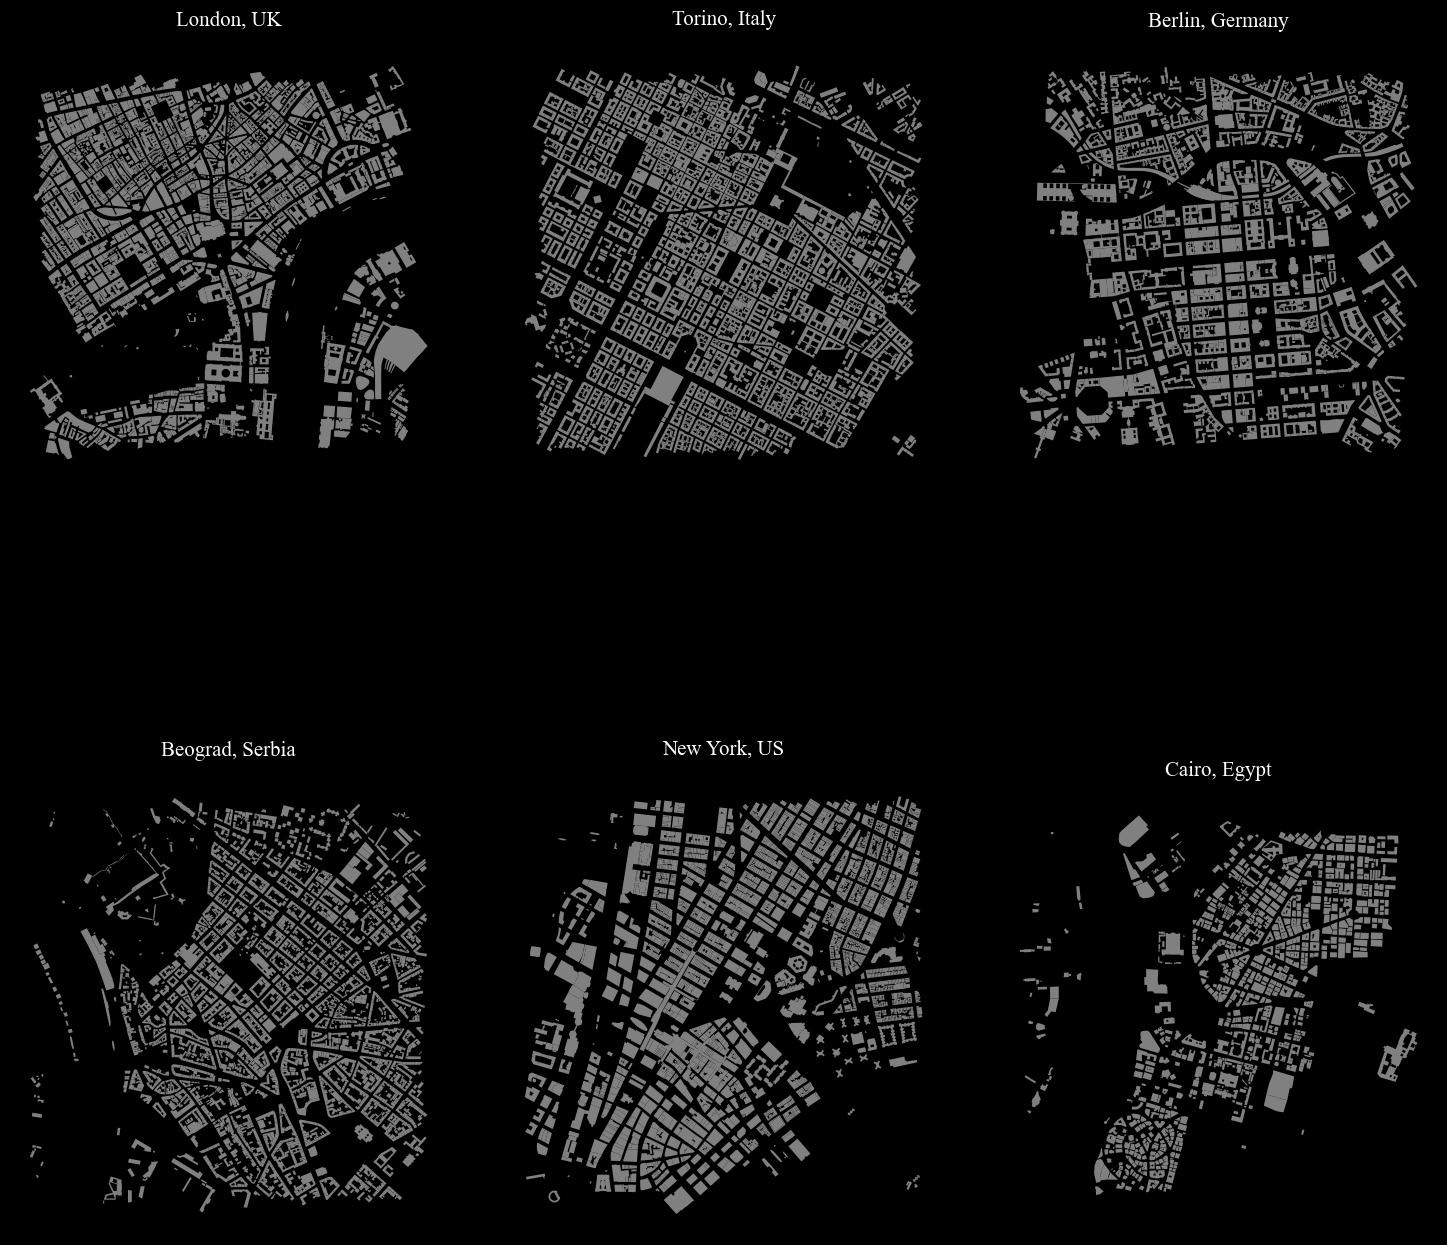

In [9]:
fig = ci.plot_grid_gdfs_column(gdfs = buildings_gdfs, titles = places, figsize = (15,15), color = 'grey', black_background = True,
                              nrows = 2, ncols = 3)

## Structural, Visual and Cultural score computations

### Structural Component

It considers:

* The area of the building.
* Its distance from the road.
* The number of adjacent buildings, within the given `neighbours_radius`, around it.
* A measure of 2d advance visibility, expanded till a maximum distance from the center of the building on the basis of the `advance_vis_expansion_distance` parameter.

In [10]:
edges_graphs = []
for n, city in enumerate(places):
    # reading the street network
    _, edges_graph = ci.get_network_fromOSM(place = city, download_method = 'distance_from_address', 
                                            distance = distance_from_center,
                                            network_type = 'walk')
    ox.projection.project_gdf(edges_graph)
    edges_graphs.append(edges_graph)

for n, city in enumerate(places):
    # structural score
    buildings = buildings_gdfs[n]
    obstructions = buildings.copy()
    edges_graph = edges_graphs[n]
    buildings_gdfs[n] = ci.structural_score(buildings, obstructions, edges_graph, advance_vis_expansion_distance = 300, 
                                neighbours_radius = 150)

## Visual Component

In [11]:
for n, city in enumerate(places):
    # visual score: not really computed at the moment as in most of the cases height information is not provided in OSM
    buildings_gdfs[n], _ = ci.visibility_score(buildings_gdfs[n])

## Cultural Component

In [12]:
for n, city in enumerate(places):
    # culturalscore:
    buildings_gdfs[n] = ci.cultural_score(buildings_gdfs[n], from_OSM = True)

## Pragmatic Score

The "radius" parameter indicates the extension of the area that is used to compute the score of a building, on the basis of
its land-use's frequency, in an area of 'buffer' meters around it.

In [42]:
# introducing classifications and possible entries

adult_entertainment = ['brothel','casino', 'swingerclub', 'stripclub', 'nightclub', 'gambling', 'private_club'] 
    
agriculture = ['shed', 'silo', 'greenhouse', 'stable', 'agricultural and forestry',  'greenhouse (botany)',  
               'building in the botanical garden']

attractions = ['attractions',   'attraction','aquarium', 'monument',  'gatehouse', 'terrace', 'tower', 'attraction and leisure',
               'information', 'viewpoint', 'tourist information center', 'recreation and amusement park',  'zoo',
               'exhibition hall, trade hall', 'boathouse', 'bath house, thermal baths', 'entertainment hall', 'sauna']

business_services = ['bank', 'service','offices', 'foundation', 'office', 'atm', 'bureau_de_change', 'post_office', 
              'post_office;atm', 'coworking_space', 'conference_centre',  'trade and services', 'trade and services building',
                      'customs office', 'insurance', 'tax_office', 'post', 'administrative building',  'facility building',
                      'residential building with trade and services', 'data_center', 'tax office']

commercial = [ 'commercial',  'retail', 'pharmacy', 'commercial;educa', 'shop', 'supermarket', 'books', 'commercial services',
              'commercial land', 'car_wash', 'internet_cafe', 'driving_school', 'marketplace', 'fuel', 'car_sharing', 
              'commercial and industry buidling',  'crematorium', 'commercial building', 'commercial and industry building',  
              'commercial building to traffic facilities (general)', 'funeral parlor', 'gas station', 'car wash',
              'pumping station','boat_rental', 'boat_sharing',  'bicycle_rental', 'car_rental', 'dive_centre',
             'ventilation_shaft'] 

culture = ['club_house','gallery', 'arts_centre','cultural facility', 'cultural_centre', 'theatre', 'cinema', 'studio',
            'exhibition_centre', 'music_school', 'theater','castle', 'museum', 'culture']
    
eating_drinking = ['bbq', 'restaurant', 'fast_food', 'cafe', 'bar',  'pub', 'accommodation, eating and drinking', 
                   'ice_cream', 'kitchen', 'food_court', 'cafe;restaurant', 'biergarten']

education_research = ['university', 'research', 'university building', 'education and research', 'research_institute',
                     'research_institu']

emergency_service = [ 'fire brigade','fire_station','police', 'emergency_service', 'resque_station', 'ranger_station',  
                     'security']

general_education = ['school', 'college', 'kindergarten', 'education', 'education and health', 'childcare',
             'language_school', 'children home',  'nursery',  'general education school']

hospitality = [ 'hotel',  'hostel', 'guest_house',  'building for accommodation',  'hotel, motel, pension',  'refuge']

industrial = ['industrial', 'factory', 'construction', 'manufacturing and production', 'gasometer', 'workshop', 
              'production building', 'manufacture']

medical_care = ['hospital', 'doctors', 'dentist','clinic','veterinary', 'medical care', 'nursing_home',  
                'sanatorium, nursing home', 'retirement home', 'healthcare', 'mortuary']

military_detainment = ['general aviation', 'barracks',  'military', 'penitentiary', 'prison', 'bunker']

other = ['toilets', 'picnic_site','hut', 'storage_tank', 'canopy','toilet',  'bunker, shelter', 'shelter','warehouse', 
         'converter',    'garage', 'garages','parking', 'block', 'roof', 'no', 'exempt','exempt 121a', 'bicycle_parking'
        'ventilation_shaft', 'wall', 'ship'] 

public = ['townhall', 'public_building',  'library','civic', 'courthouse', 'public', 'embassy',
          'public infrastructure', 'community_centre', 'court',  'district government', 'government',
          'residential building with public facilities']

religious = ['church', 'place_of_worship','convent', 'rectory', 'chapel', 'religious building', 'monastery', 'nuns home',
              'vocational school',  'cathedral', 'religious buildings', 'synagogue', 'basilica']
residential = [ 'apartments', None, 'NaN', 'residential','flats', 'houses', 'building', 'residential land', 
               'residential building', 'student dorm', 'building usage mixed with living', 'house'
              'exempt', 'apartments 4-6 units', 'apartments 7 units above', 'residential condo unit', 'mixed use res/comm',
             'residential three family', 'residential two family','house', 'commercial condo unit', 'condominium master',
               'condominium parking', 'residential single family']

social = ['social_facility', 'community_centre', 'community buidling', 'dormitory', 'social_centre', 'social serives building', 
         'social services',  'community hall',  'commercial social facility',  'recreational']

sport = ['stadium', 'sport and entertainment', 'sports or exercise facility', 'gym', 'sports building', 'sports hall', 
         'horse riding school',  'swimming pool',  'sport hall', 'bowling hall',  'indoor swimming pool', 'grandstand']

transport = ['transport', 'road transport', 'station', 'subway_entrance', 'bus_station', 'shipping facility building', 
             'train_station',  'railway building',  'railway station and london underground station', 'railway station',
            'london underground station', 'light rapid transit station', 'light rapid transit station and railway station', 'ship'
            'transportation']

utilities = ['gas supply', 'electricity supply', 'electricity substation', 'waste treatment building',
            'water supply', 'waste water treatment plant', 'smokestack', 'supply systems', 'waste management', 'water works',
              'heating plant', 'boiler house',  'telecommunication','electricity']


['society', 'trade_union', 'boat', 'air_shaft', 'kiosk', 'container', 'retail;yes', 'barn', 'palace', 'arch']
['bridge', 'ruins']
['steps', 'bridge', 'opera_house', 'mall', 'ruins', 'bunker', 'viaduct', 'container', 'gate']
['planetarium', 'gazebo', 'abandoned', 'detached', 'mosque', 'transportation', 'houseboat', 'ferry_terminal']
['pavilion', 'stock_exchange', 'kiosk']
['yes;public'

In [44]:
categories = [adult_entertainment, agriculture, attractions, business_services, commercial, culture, eating_drinking,
       education_research, emergency_service, general_education, hospitality, industrial, medical_care, military_detainment,
       other, public, religious, residential, social, sport, transport, utilities]
strings = ['adult_entertainment', 'agriculture', 'attractions', 'business_services', 'commercial', 'culture', 'eating_drinking',
       'education_research', 'emergency_service', 'general_education', 'hospitality', 'industrial', 'medical_care', 
           'military_detainment', 'other', 'public', 'religious', 'residential', 'social', 'sport', 'transport', 'utilities']

In [45]:
for n, city in enumerate(places):
    all_uses = [item for sublist in categories for item in sublist]
    land_uses = list(buildings_gdfs[n].land_use_raw.unique())
    to_categorise = [item for item in land_uses if item not in all_uses]
    print(to_categorise)

['society', 'trade_union', 'boat', 'air_shaft', 'kiosk', 'container', 'retail;yes', 'barn', 'palace', 'arch']
['bridge', 'ruins']
['steps', 'bridge', 'opera_house', 'mall', 'ruins', 'bunker', 'viaduct', 'container', 'gate']
['planetarium', 'gazebo', 'abandoned', 'detached', 'mosque', 'transportation', 'houseboat', 'ferry_terminal']
['pavilion', 'stock_exchange', 'kiosk']
['yes;public']


In [16]:
for n, city in enumerate(places):
    buildings_gdfs[n]['land_use_raw'] = buildings_gdfs[n]['land_use_raw'].str.lower()
    buildings_gdfs[n] = ci.classify_land_use(buildings_gdfs[n], 'land_use','land_use_raw', categories, strings)
    buildings_gdfs[n] = ci.pragmatic_score(buildings_gdfs[n], research_radius = 200)

In [ ]:
# visualising land use categorisation
nr_categories = max([len(gdf['land_use'].unique()) for gdf in buildings_gdfs])
cmap = ci.rand_cmap(nr_categories, type_color = 'bright')

legend_ax 0
legend_fig 1
legend_ax 2
legend_ax 3
legend_ax 4
legend_ax 5


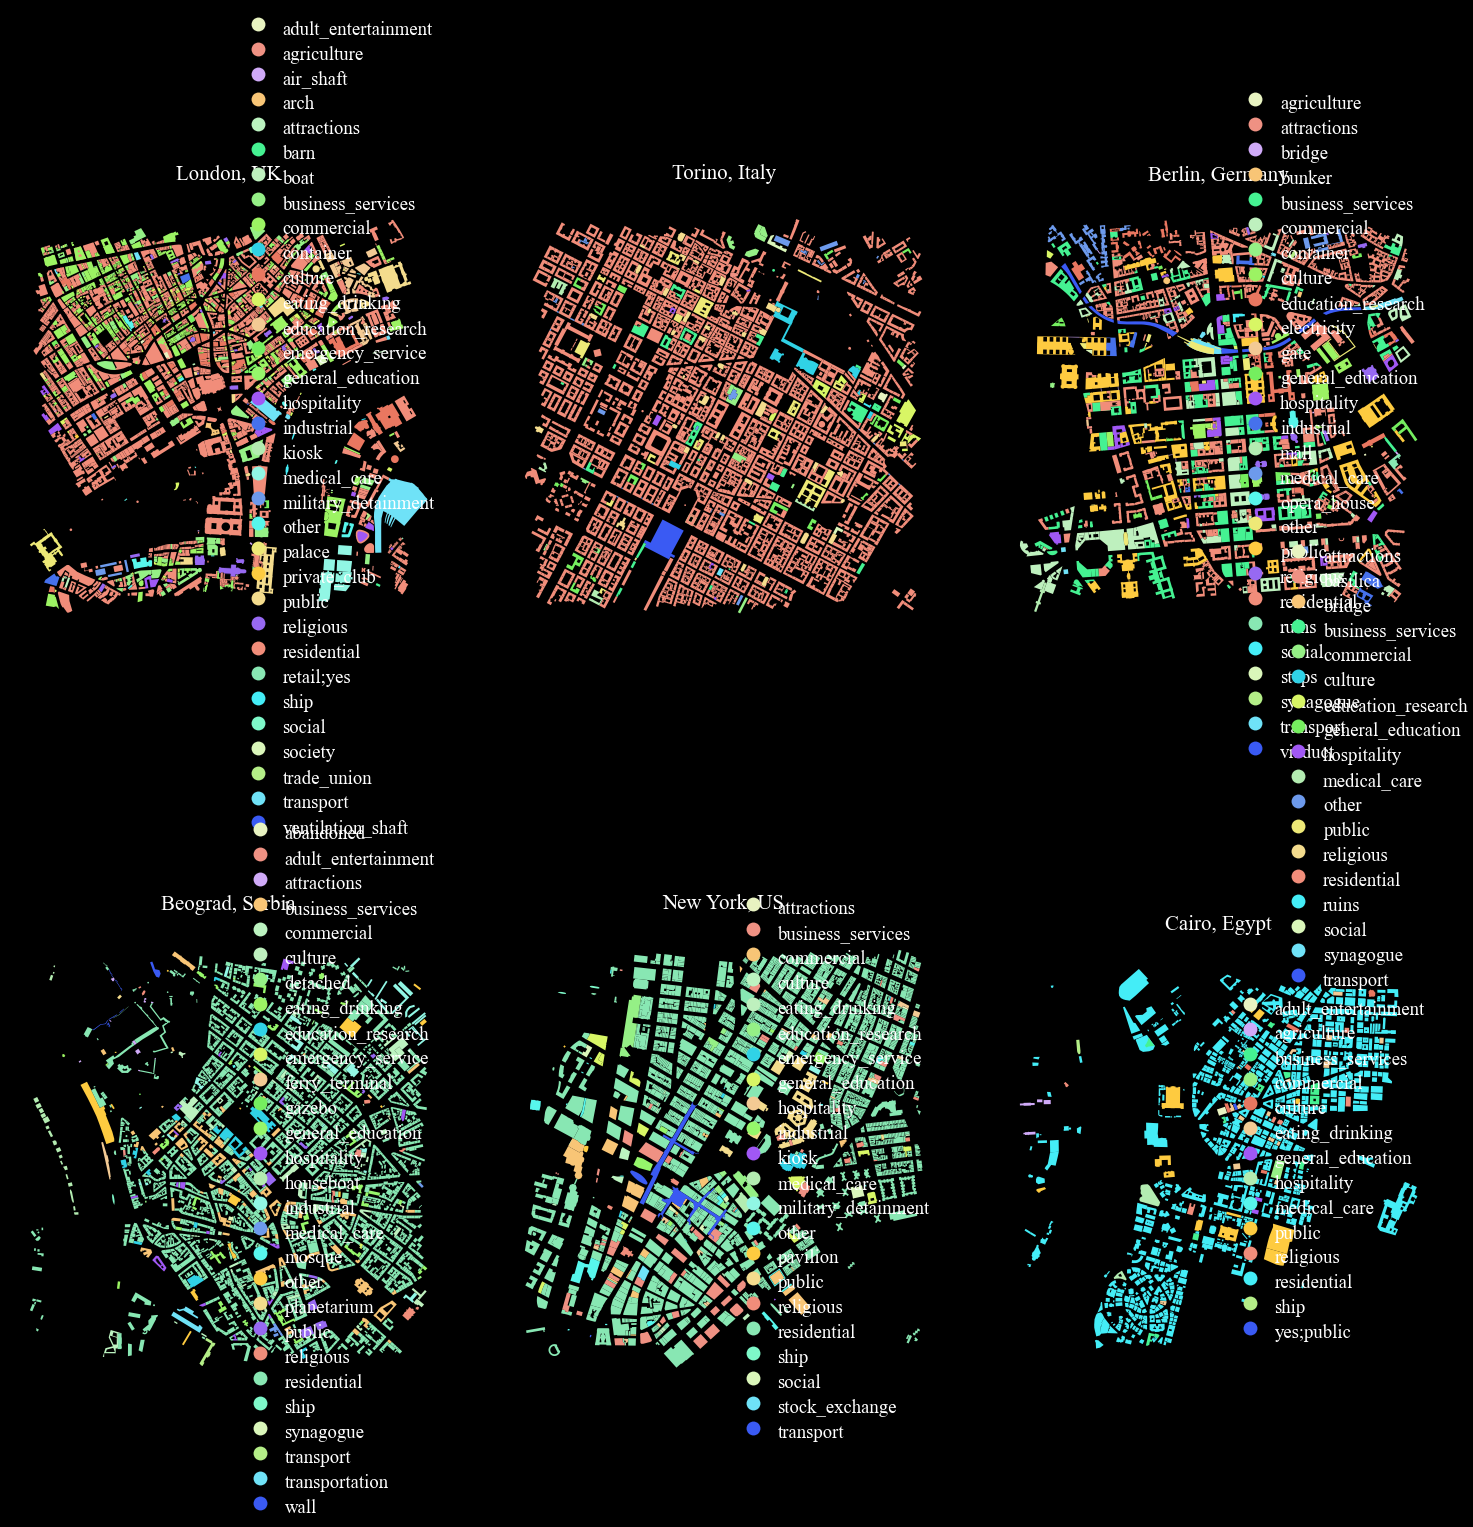

In [38]:
fig = plot_grid_gdfs_column(buildings_gdfs,titles = places, cmap = cmap, column = 'land_use', nrows = 2, ncols = 3,
                              legend = True)

In [37]:
def plot_grid_gdfs_column(gdfs = [], column = None, ncols = 1, nrows = 1, titles = [], black_background = True, figsize = (15,15), scheme = None, bins = None, 
                classes = None, norm = None, cmap = None, color = None, alpha = None, geometry_size = None, geometry_size_columns = [], 
                          geometry_size_factor = None,
                legend = False, fontsize = 15, cbar = False, cbar_ticks = 5, cbar_max_symbol = False, cbar_min_max = False, cbar_shrink = 0.75, 
                          axes_frame = False):
  
    if (len(gdfs)+1 != ncols*nrows) & (len(gdfs) != ncols*nrows):
        raise ValueError("Please provide an appropriate combination of nrows and ncols")
    
    multiPlot = MultiPlot(figsize = figsize, nrows = nrows, ncols = ncols, black_background = black_background, fontsize = fontsize)
    if (cbar) & (norm is None):
        min_value = min([gdf[column].min() for gdf in gdfs])
        max_value = max([gdf[column].max() for gdf in gdfs])
        norm = plt.Normalize(vmin = min_value, vmax = max_value)
    
    for n, ax in enumerate(multiPlot.grid.flat):
        if n > len(gdfs)-1: 
            ax.set_visible(False)    
            continue    
        gdf = gdfs[n]
          
        parameters = {'ax': ax, 'n': n, 'multiPlot': multiPlot, 'column': column , 'gdf': gdf, 'titles': titles, 
                      'scheme': scheme, 'bins': bins, 'classes': classes, 'norm': norm, 'cmap': cmap, 
                      'color': color, 'alpha': alpha, 'legend': legend, 'axes_frame': axes_frame,
                      'geometry_size': geometry_size, 'geometry_size_columns': geometry_size_columns, 'geometry_size_factor': geometry_size_factor}        
        subplot(**parameters)    
            
    if (cbar) & (not legend):  
        generate_colorbar(plot = multiPlot, cmap = cmap, norm = norm, cbar_ticks = cbar_ticks, cbar_max_symbol = cbar_max_symbol, cbar_min_max = cbar_min_max, 
                    cbar_shrink = cbar_shrink)

    return multiPlot.fig                      

def plotOn_ax(ax, gdf, column = None, scheme = None, bins = None, classes = 7, norm = None, cmap = None, color = 'red', alpha = 1.0, 
                geometry_size = 1.0, geometry_size_column = None, geometry_size_factor = None, legend = False, zorder = 0):
    
    gdf = gdf.copy()

    categorical = not (norm is not None) | (scheme is not None)
    if not categorical:
        color = None
        if cmap is None:
            cmap = kindlmann()
        if norm is not None:
            scheme = None
        if (gdf[column].dtype != 'O' ):
            gdf = gdf.reindex(gdf[column].abs().sort_values(ascending = True).index)
        else:
            gdf[column] = gdf[column].astype(float)
            
    elif (column is not None) & (cmap is None):
        cmap = rand_cmap(len(gdf[column].unique())) 
        if len(gdf[column].unique()) == 1:
            legend = False
            cmap = None
            color = 'red'
        
    c_k = dict(k=classes) if bins is None else dict(bins=bins, k=len(bins))
    scheme = 'User_Defined' if bins is not None else scheme
    
    parameters = {'ax': ax, 'column': column, 'classification_kwds': c_k, 'scheme': scheme, 'norm': norm,
                   'cmap': cmap, 'categorical': categorical, 'color': color, 'alpha': alpha, 'legend': legend, 
                   'zorder': zorder}  
                   
    geometry_type = gdf.iloc[0].geometry.geom_type
    if geometry_type == 'Point':    
        if (geometry_size_factor is not None): 
            gdf[column+'_sc'] = scaling_columnDF(gdf[column])
            geometry_size = np.where(gdf[column+'_sc'] >= 0.20, gdf[column+'_sc']*geometry_size_factor, 0.40) # marker size
        parameters['markersize'] = geometry_size
    elif geometry_type == 'LineString':
        if geometry_size_factor is not None:
            geometry_size = [(abs(value)*geometry_size_factor) if (abs(value)*geometry_size_factor) > 1.1 else 1.1 for value in
                             gdf[column]]
        sub_parameters = {'linewidth': geometry_size, 'capstyle': 'round', 'joinstyle':'round'}
        parameters.update(sub_parameters)
    else:
        parameters['edgecolor'] = 'none' 
    
    gdf.plot(**parameters) 
 
 
def subplot(ax, n, multiPlot, gdf, column, titles, scheme, bins, classes, norm, cmap, color, alpha, geometry_size, geometry_size_columns,
                    geometry_size_factor, legend, axes_frame):
    ax.set_aspect("equal")
    set_axes_frame(axes_frame, ax, multiPlot.black_background, multiPlot.text_color)
    
    if titles:          
        ax.set_title(titles[n], loc='center', fontfamily = 'Times New Roman', fontsize = multiPlot.font_size_primary, color = multiPlot.text_color, 
                     pad = 15)    
    
    geometry_size_column = column
    if geometry_size_columns:
        geometry_size_column = geometry_size_columns[n]
   
    legend_ax = False
    legend_fig = False
    
    if legend:
        legend_ax = (n == 1 and scheme == 'User_Defined') or  or (n == 1 and scheme == None and column != None) or (scheme != 'User_Defined') 
        legend_fig = (n == 1 and scheme == 'User_Defined') or (n == 1 and scheme == None and column != None)

    plotOn_ax(ax, gdf, column = column, scheme = scheme, bins = bins, classes = classes, norm = norm, cmap = cmap, color = color, 
                alpha = alpha, legend = legend_ax, geometry_size = geometry_size, geometry_size_column = geometry_size_column, 
                geometry_size_factor = geometry_size_factor)
                
    if legend_fig:
        print("legend_fig", n)
        generate_legend_fig(ax, multiPlot)
    elif legend_ax:
        print("legend_ax", n)
        generate_legend_ax(ax, multiPlot)
   
def generate_legend_fig(ax, plot):
    """ 
    It generates the legend for an entire figure.
    
    Parameters
    ----------
    ax: matplotlib.axes object
        The axes object on which to create the subplot.
    plot: Plot, MultiPlot Object
        The Plot object.
    
    """ 
    leg = ax.get_legend()    
    fig_leg = plot.fig.legend(handles = leg.legend_handles, labels = [t.get_text() for t in leg.texts], loc=5, 
                              borderaxespad= 0)
    ax.get_legend().remove()
    plt.setp(fig_leg.texts, family='Times New Roman', fontsize = plot.font_size_secondary, color = plot.text_color, 
             va = 'center')

    fig_leg.get_frame().set_linewidth(0.0) # remove legend border
    fig_leg.set_zorder(102)
    fig_leg.get_frame().set_facecolor('none')

    for handle in fig_leg.legend_handles:
        if not isinstance(handle, Line2D):
            handle._legmarker.set_markersize(15)
        else: 
            break
           
def generate_legend_ax(ax, plot):
    """ 
    It generate the legend for an axes.
    
    Parameters
    ----------
    ax: matplotlib.axes object
        The axes object on which to create the subplot.
    plot: Plot, MultiPlot Object
        The Plot object.
    """
    leg = ax.get_legend()  
    plt.setp(leg.texts, family='Times New Roman', fontsize = plot.font_size_secondary, color = plot.text_color, va = 'center')
    
    bbox_legend = leg.get_window_extent()
    bbox_axes = ax.get_window_extent()
    legend_height = bbox_legend.y1 - bbox_legend.y0
    axes_height = bbox_axes.y1 - bbox_axes.y0
    vertical_position = 0.5+(legend_height/2/axes_height)
    
    leg.set_bbox_to_anchor((1.0, vertical_position))
    
    leg.get_frame().set_linewidth(0.0) # remove legend border
    leg.set_zorder(102)
    
    for handle in leg.legend_handles:
        if not isinstance(handle, Line2D):
            handle._legmarker.set_markersize(12)
        else:
            break
    leg.get_frame().set_facecolor('none')
    
def generate_colorbar(plot = None, cmap = None, norm = None, cbar_ticks = 5, cbar_max_symbol = False, cbar_min_max = False, cbar_shrink = 0.95):
    """ 
    It plots a colorbar, given some settings.
    
    Parameters
    ----------
    plot: Plot, MultiPlot Object
        The Plot object.
    cmap: str or matplotlib.colors.LinearSegmentedColormap
        Color map for the plot. See matplotlib colormaps for a list of possible values or pass a colormap.
    norm: array
        A class that specifies a desired data normalisation into a [min, max] interval.
    cbar_ticks: int
        Number of ticks along the colorbar.
    cbar_max_symbol: bool
        If True, show the ">" next to the highest tick's label in the colorbar (useful when normalizing).
    cbar_min_max: bool
        If True, only show the ">" and "<" as labels of the lowest and highest ticks' the colorbar.
    cbar_shrink:
        Fraction by which to multiply the size of the colorbar. 
    """
    
    if isinstance(plot, Plot):
        ax = plot.ax
    else:
        ax = plot.grid
        
    cb = plot.fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax, shrink = cbar_shrink)
    tick_locator = ticker.MaxNLocator(nbins=cbar_ticks)
    cb.locator = tick_locator
    cb.update_ticks()
    cb.outline.set_visible(False)

    ticks = list(cb.get_ticks())
    for t in ticks: 
        if (t == ticks[-1]) & (t != norm.vmax) :
            ticks[-1] = norm.vmax

    if cbar_min_max:
        ticks = [norm.vmin, norm.vmax]
    
    cb.set_ticks(ticks)
    cb.ax.set_yticklabels([round(t,1) for t in ticks])
    if cbar_max_symbol:
        cb.ax.set_yticklabels([round(t,1) if t < norm.vmax else "> "+str(round(t,1)) for t in cb.ax.get_yticks()])

    plt.setp(plt.getp(cb.ax, "yticklabels"), color = plot.text_color, fontfamily = 'Times New Roman', fontsize= plot.font_size_secondary)
                
def set_axes_frame(axes_frame = False, ax = None, black_background = False, text_color = 'black'):
    """ 
    It draws the axis frame.
    
    Parameters
    ----------
    axes_frame: bool
        Flag indicating whether to draw axes frame or not.
    ax: matplotlib.axes object
        The axes object on which to create the subplot.
    black_background: boolean
        It indicates whether the background color is black.
    text_color: str
        The text color.
    """
    if not axes_frame:
        ax.set_axis_off()
        return
      
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.tick_params(axis= 'both', which= 'both', length=0)
    
    for spine in ax.spines:
        ax.spines[spine].set_color(text_color)
    if black_background: 
        ax.set_facecolor('black')

## Final scores

### Weights definition.
#### Weights of components and indexes that are not computed due to data availability are set to 0

In [5]:
# global landmarkness components weights
g_cW = {'vScore': 0.00, 'sScore' : 0.60, 'cScore': 0.10, 'pScore': 0.30}
# global landmarkness indexes weights, cScore and pScore have only 1 index each
g_iW = {'3dvis': 0.00, 'fac': 0.00, 'height': 0.00, 'area': 0.50, '2dvis': 0.00, 'neigh': 0.30 , 'road': 0.20}

# # local landmarkness components weights
l_cW = {'vScore': 0.05, 'sScore' : 0.45, 'cScore':0.10 , 'pScore': 0.45}
# # local landmarkness indexes weights, cScore and pScore have only 1 index each
l_iW = {'3dvis': 0.00, 'fac': 0.00, 'height': 0.00, 'area': 0.50, '2dvis': 0.00, 'neigh': 0.30 , 'road': 0.20}

In [7]:
# Global and Local Score (1500 mt area)
for n, city in enumerate(places):
    buildings_gdfs[n] = ci.compute_global_scores(buildings_gdfs[n], g_cW, g_iW)
    buildings_gdfs[n] = ci.compute_local_scores(buildings_gdfs[n], l_cW, l_iW, 1500)

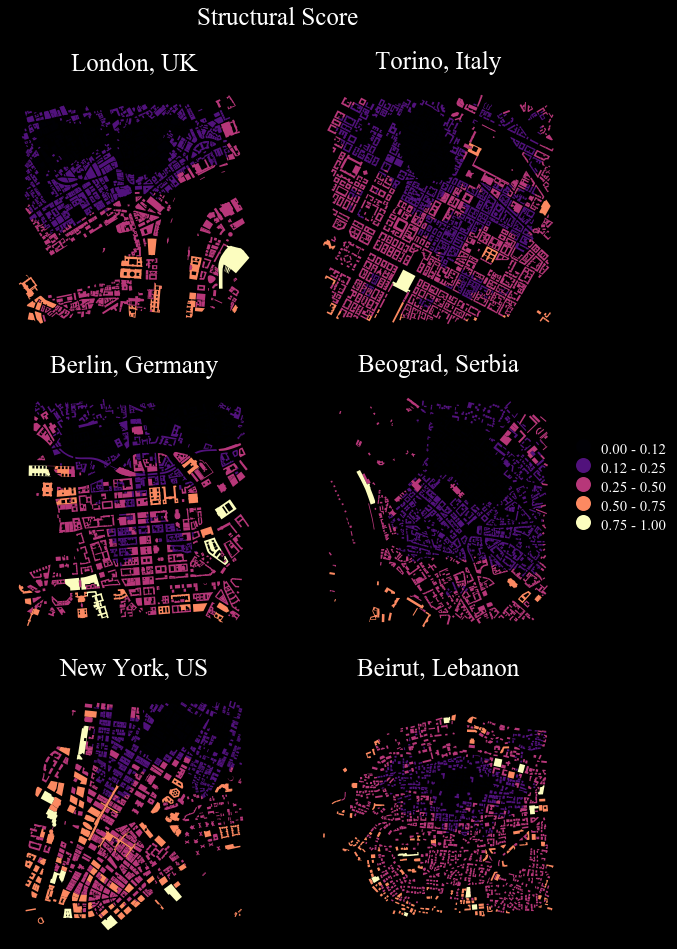

In [434]:
# visualising the four componets' maps, the color bar can be activated adding: cbar = True
fig = plot_gdfs(buildings_gdfs, main_title = "Structural Score", titles = places, classes = 7, column = 'sScore_sc',
                cmap = 'magma', scheme = 'Lynch_Breaks', legend = True, fig_size = 10)

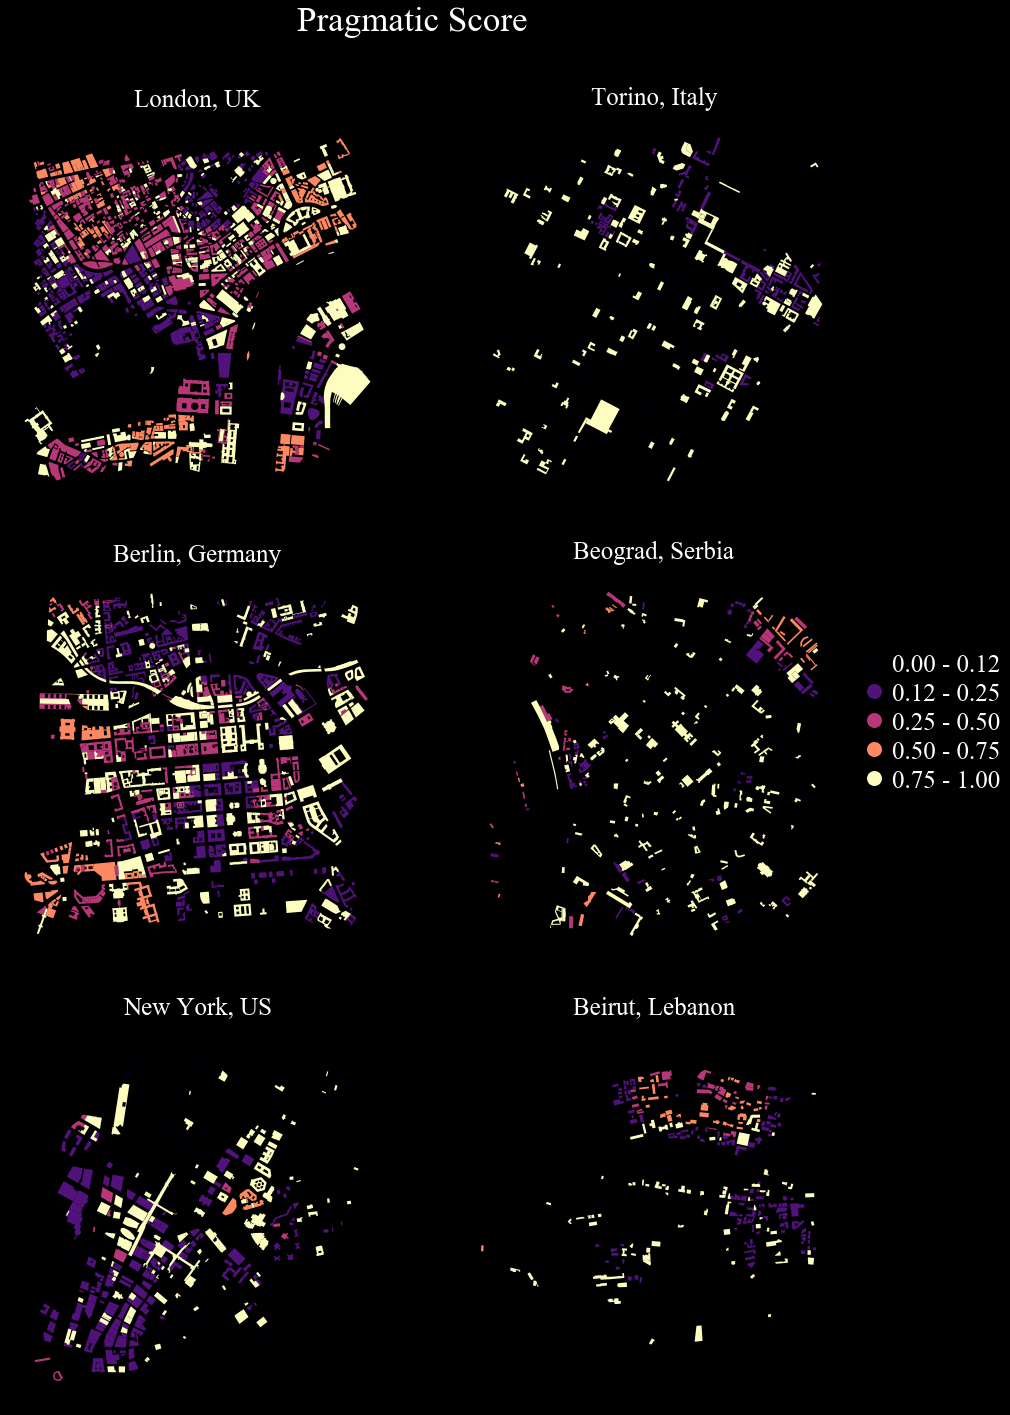

In [416]:
fig = ci.plot_gdfs(buildings_gdfs, main_title = "Pragmatic Score", titles = places, column = 'pScore',
                cmap = 'magma', scheme = 'Lynch_Breaks', legend = True)

In [433]:
buildings_gdfs[0].lScore_sc

858    nan
954    nan
1078   nan
1092   nan
1230   nan
        ..
397    nan
1455   nan
1112   nan
324    nan
321    nan
Name: lScore_sc, Length: 1489, dtype: float64

ValueError: Fewer unique values than specified classes.

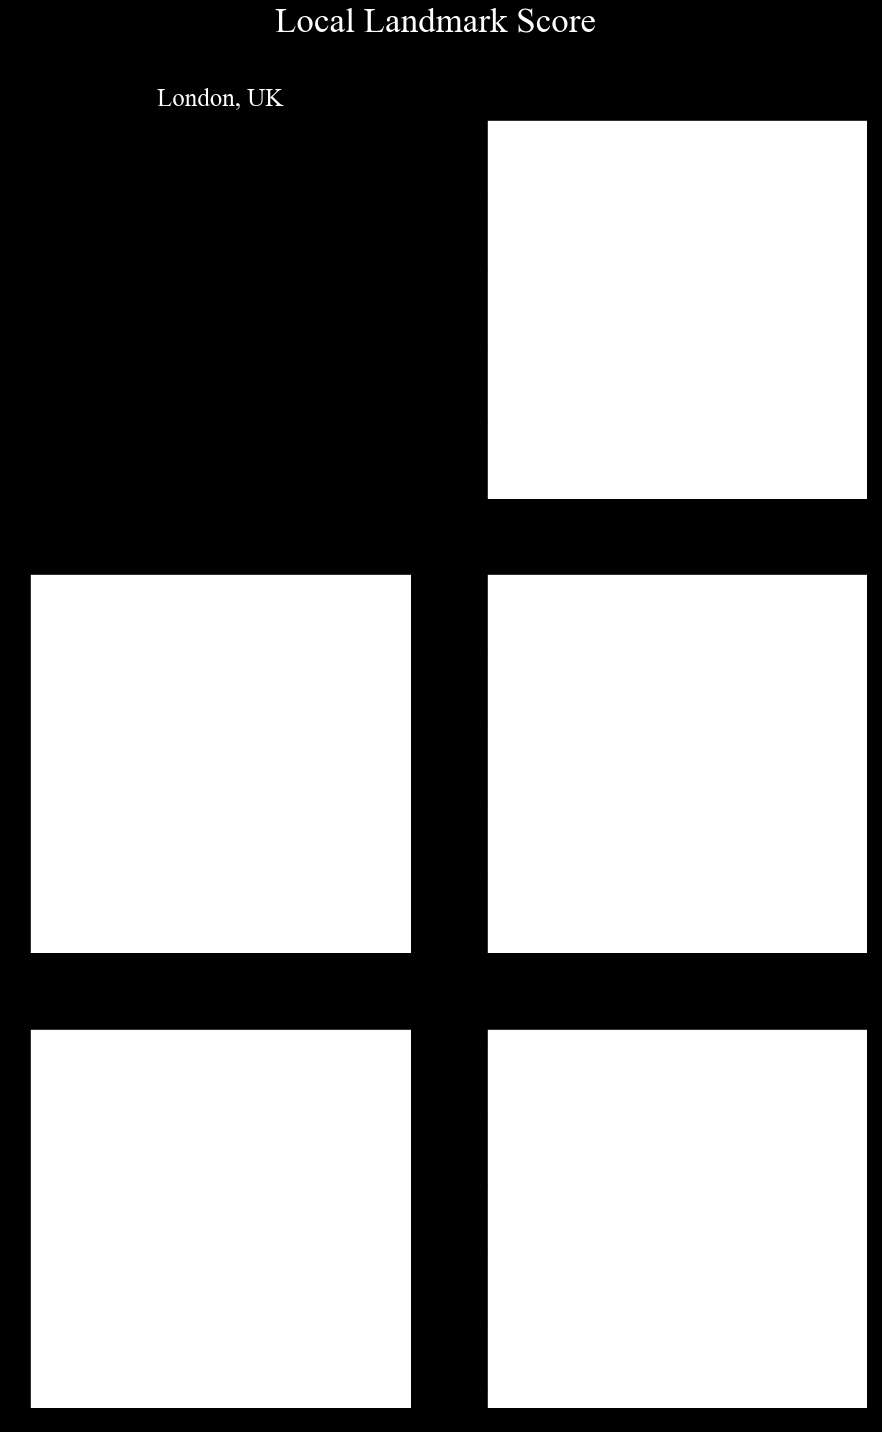

In [430]:
fig = plot_gdfs(buildings_gdfs, main_title = "Local Landmark Score", titles = places, column = 'lScore',
                cmap = 'magma', scheme = 'Fisher_Jenks', legend = True)

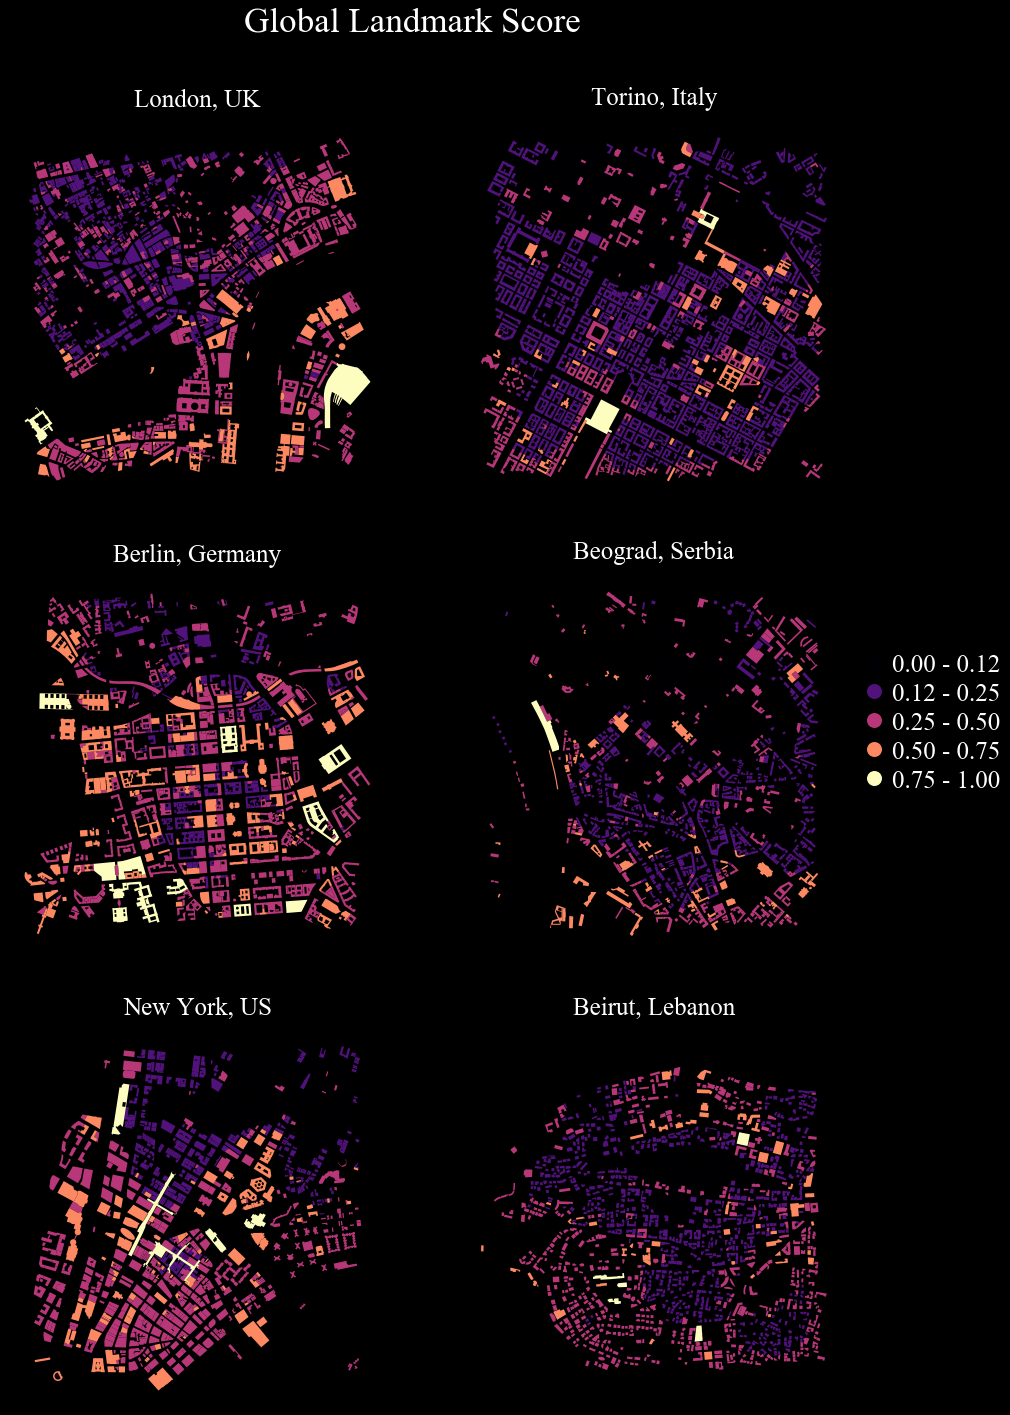

In [414]:
fig = ci.plot_gdfs(buildings_gdfs, main_title = "Global Landmark Score", titles = places, column = 'gScore_sc',
                cmap = 'magma', scheme = 'Lynch_Breaks', legend = True)